# [Exploration 09] 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

## 프로젝트 설명 
- 캐글 베이스라인 구축하는 방법
- 하이퍼 파라미터 튜닝을 통해 캐글 스코어 올리기   


## 프로젝트 목표
- MF모델, AlternatingLeastSquares모델에 대해 이해하기
- 아이템, 유저/유사도, 기여도에 대해 이해하기

## 01. load and preprocess data

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/Projects/Project_Aiffel/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- date 문자열 전처리

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)  # int로 변경
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- target data인 price 처리

In [5]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- id 컬럼 삭제

In [6]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


- test data도 똑같이 전처리 해줍니다.
    - 단 price는 없음 

In [8]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- target data 전처리

In [9]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

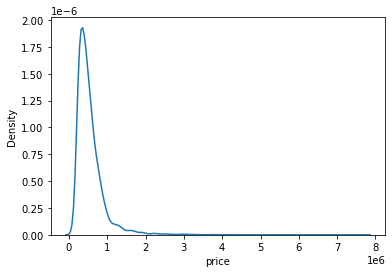

In [10]:
sns.kdeplot(y)
plt.show()

- 분포와 price값 스케일이 크다.
- 왼쪽으로 치우쳐져있는 price를 로그 변환처리해준다.

In [11]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

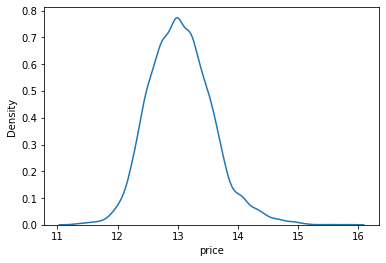

In [12]:
sns.kdeplot(y)
plt.show()

- 데이터의 스케일이 작아졌고, 분포도 정규분포와 비슷한 형태로 바뀌었다. 

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 02. build and train model
- 하이퍼 파라미터 조정을 위한 함수 생성

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [15]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  # np.expml : 원래 스케일로 되돌리기

In [16]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [17]:
random_state=2021

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [18]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [19]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 137616.54606168193,
 'XGBRegressor': 126848.45135868828,
 'LGBMRegressor': 128291.75333011308,
 'RandomForestRegressor': 136497.21550154834}

- 위의 과정을 함수로 생성

In [20]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,137616.546062
RandomForestRegressor,136497.215502
LGBMRegressor,128291.753330
XGBRegressor,126848.451359


## 03. tune hyperparameter
- 그리드 탐색

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100],
    'max_depth': [10], 
    'gamma': [0.5],
    'learning_rate': [0.01, 0.03, 0.05, 0.001]
    
    
    
}

In [59]:
# model = LGBMRegressor(random_state=random_state)
model = xgboost

In [60]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   15.3s finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=12,
                                    num_parallel_tree=1, random_state=2021,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
  

In [61]:
import sklearn
sklearn. __version__ 

'0.23.1'

**keyerror base_score**   
    : sklearn version 0.23.0 -> 0.23.1로 업그레이드 후 해결   
- 결과 확인

In [62]:
grid_model.cv_results_

{'mean_fit_time': array([2.04944386, 4.16671076, 6.18772407, 1.72661667]),
 'std_fit_time': array([0.12420527, 0.21394179, 0.28537629, 0.30736144]),
 'mean_score_time': array([0.01877766, 0.03170443, 0.04091449, 0.02249336]),
 'std_score_time': array([0.00416304, 0.00487297, 0.02296786, 0.01695109]),
 'param_gamma': masked_array(data=[0.5, 0.5, 0.5, 0.5],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.01, 0.03, 0.05, 0.001],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 10, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 100, 100, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0.5,
   'learning_rate': 0.0

In [63]:
params = grid_model.cv_results_['params']
params

[{'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100},
 {'gamma': 0.5, 'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 100},
 {'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100},
 {'gamma': 0.5, 'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100}]

In [64]:
score = grid_model.cv_results_['mean_test_score']
score

array([-2.12184724e+01, -3.98483505e-01, -3.60070441e-02, -1.29155711e+02])

In [65]:
results = pd.DataFrame(params)
results['score'] = score

results

,gamma,learning_rate,max_depth,n_estimators,score
0,0.5,0.010,10,100,-21.218472
1,0.5,0.030,10,100,-0.398484
2,0.5,0.050,10,100,-0.036007
3,0.5,0.001,10,100,-129.155711


In [66]:
grid_model.best_params_

{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}

In [67]:
results['RMSLE'] = np.sqrt(-1 * results['score'])
results

,gamma,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.5,0.010,10,100,-21.218472,4.606351
1,0.5,0.030,10,100,-0.398484,0.631255
2,0.5,0.050,10,100,-0.036007,0.189755
3,0.5,0.001,10,100,-129.155711,11.364669


- RMSLE를 기준으로 정렬

In [68]:
results = results.sort_values('RMSLE')
results

,gamma,learning_rate,max_depth,n_estimators,score,RMSLE
2,0.5,0.050,10,100,-0.036007,0.189755
1,0.5,0.030,10,100,-0.398484,0.631255
0,0.5,0.010,10,100,-21.218472,4.606351
3,0.5,0.001,10,100,-129.155711,11.364669


- 그리드 탐색을 통해, 최적의 하이퍼 파라미터를 알 수 있었다.(lgb, xgboost)
    - gamma = 0.5
    - learning rate = 0.05
    - max depth = 10
    - n_estimators = 100
    
## 04. 함수로 튜닝하면서 학습하기

In [48]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [49]:
# model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model = XGBRegressor(max_depth=10, n_estimators=100, random_state=random_state)

model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.095005 , 13.0386715, 14.064271 , ..., 13.117246 , 12.708554 ,
       13.107719 ], dtype=float32)

- 로그변환했던 것을 되돌려서 원래 스케일로 만들기

prediction = np.expm1(prediction)
prediction

In [50]:
data_dir = os.getenv('HOME')+'/Projects/Project_Aiffel/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


- sample 프레임에 학습으로 예측한 값을 붙여주기

In [51]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,13.095005
1,15036,13.038671
2,15037,14.064271
3,15038,12.611727
4,15039,12.701734


In [52]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel-dj26/Projects/Project_Aiffel/data/submission_lgbm_RMSLE_0.164399.csv


In [55]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/Projects/Project_Aiffel/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [57]:
save_submission(model, train, y, test, 'xgboost', rmsle='0.175284')

/home/aiffel-dj26/Projects/Project_Aiffel/data/submission_xgboost_RMSLE_0.175284.csv saved!


- 최적의 하이퍼 파라미터를 이용해 앙상블 학습을 하고자 함

In [ ]:
gboost = GradientBoostingRegressor(random_state=2021)
xgboost = xgb.XGBRegressor(random_state=2021)
lightgbm = lgb.LGBMRegressor(random_state=2021)

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

# 정리     
---        
1. 데이터 준비와 전처리
    - ratings에 있는 유니크한 영화 개수
    - rating에 있는 유니크한 사용자 수
    - 가장 인기 있는 영화 30개(인기순)
    - meta data(movies)와 ratings를 합친다.
    - 평점 3점 이하의 데이터는 삭제한다.
2. 내가 선호하는 영화를 5가지 골라서 rating에 추가
    - 이를 통해서 후에 학습한 모델을 평가한다.
3. CSR matrix 생성
4. als_model = AlternatingLeastSquares 모델 구성 후 학습
5. 모델 평가
    - 추가한 데이터를 통해 선호도 추출
    - 비슷한 영화 추출
    - 사용자에게 추천하기


# 루브릭 평가
---
1. **캐글 데이터분석 전과정이 성공적으로 진행되었는가?**   
    - 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.


2. **전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?**  
    - 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.
    
     
3. **회귀모델 예측정확도가 기준 이상 높게 나왔는가?**  
    - 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

    
# 회고
---
## 느낀 점
- 영화 데이터 중 아는 영화가 거의 없어서 장르를 기준으로 판단할 수 밖에 없었던 점이 아쉬웠다.
- MF 매트릭스, ALS 모델이 어떻게 구성되는지 공부할 수 있었다.
- 하지만 단지 선호 여부에 따라서만 판단하는 점이 아쉽다.
- 보다 세밀하게 구성되어있는 모델을 공부해보고 싶다. 